# **Модель, распознающая эмоции**
Здесь описано создание и обучение модели, распознающей эмоции по фотографии.

## Эмоции
Модель распознает 7 базовых эмоций по Экману:
- злость (ANGER)
- отвращение (DISGUST)
- страх (FEAR)
- счастье (HAPPINESS)
- грусть (SAD)
- удивление (SURPRISE)
- нейтральное выражение (NEUTRAL)

Инициализируем массив эмоций

In [0]:
emotions = [(0, "ANGER"), (1, "DISGUST"), (2, "FEAR"), (3, "HAPPINESS"), 
            (4, "SAD"), (5, "SURPRISE"), (6, "NEUTRAL")]

## Датасет
Для обучения, будем использовать датасет fer2013. Найти его можно [здесь](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). Загрузите его и поместите в папку с этим файлом.
Или можно примонтировать Google Drive, если используется Google Colab.

In [70]:
# Монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Путь до датасета, укажите свой
fer_dataset_path = "/content/drive/My Drive/university/reko/fer2013.csv"

## Подготовка данных
Для обучения подготавливаем данные. Грузим датасет. Изображения в датасете имеют размер 48х48 пикселей

In [0]:
import pandas as pd
import numpy as np

In [0]:
width, height = 48, 48
data = pd.read_csv(fer_dataset_path)

Данные в датасете хранятся в виде векторов целых чисел. В столбце emotion указан идентификатор эмоции (ассоциативный массив определен выше), а pixels - это 2304 (48х48) чисел изображения, пиксели. Пример как это хранится внутри csv файла ниже:

In [0]:
data[:5]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
datapoints = data['pixels'].tolist()

all_images = []
for images in datapoints:
  # преобразуем из строки в массив чисел
  x = [int(image) for image in images.split(' ')]
  # преобразуем одномерный массив в матрицу
  x = np.asarray(x).reshape(width, height)
  # добавляем изображение в список всех изображений
  all_images.append(x.astype('float32'))

In [0]:
# преобразование к массиву numpy
all_images = np.asarray(all_images)
all_images = np.expand_dims(all_images, -1)

Считываем эмоции:

In [77]:
all_emotions = pd.get_dummies(data['emotion'])
all_emotions

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
35882,0,0,0,0,0,0,1
35883,0,0,0,1,0,0,0
35884,1,0,0,0,0,0,0
35885,0,0,0,1,0,0,0


## Модель
Для распознавания эмоций на изображении лучше всего использовать сверточную нейронную сеть. Для построения модели будем использовать Keras и TensorFlow. Делаем нужные импорты

In [0]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os

Так же задаем нужные константы

In [0]:
num_features = 64 # количество признаков
num_labels = len(emotions) # количество эмоций
batch_size = 64 # каким размером партии данных обучать
epochs = 100 # количество эпох, сколько раз обучать

Разделяем данные для теста, обучения и валидации

In [156]:
train_images, test_images, train_emotions, test_emotions = train_test_split(all_images, all_emotions, test_size=0.1, random_state=42)
train_images, valid_images, train_emotions, valid_emotions = train_test_split(train_images, train_emotions, test_size=0.1, random_state=41)

print("Размер тестовой подборки: {0}".format(len(test_images)))
print("Размер обучающей подборки: {0}".format(len(train_images)))
print("Размер валидационной подборки: {0}".format(len(valid_images)))

Размер тестовой подборки: 3589
Размер обучающей подборки: 29068
Размер валидационной подборки: 3230


Сама сверточная нейронная сеть построена следующим образом

In [0]:
def create_model():
  model = Sequential()

  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))

  return model

In [146]:
model = create_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_63 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_64 (Batc (None, 23, 23, 128)      

Модель создана, теперь следует её скопилировать и обучить.

In [0]:
def train_model(model, x_set, y_set, x_valid, y_valid):
  model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
  
  model.fit(x_set, y_set,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid, y_valid),
          shuffle=True)

In [148]:
train_model(model, train_images, train_emotions, valid_images, valid_emotions)

Epoch 1/100
455/455 [==============================] - 12s 27ms/step - loss: 2.0132 - accuracy: 0.2163 - val_loss: 1.8171 - val_accuracy: 0.2594
Epoch 2/100
455/455 [==============================] - 12s 26ms/step - loss: 1.8340 - accuracy: 0.2529 - val_loss: 1.8202 - val_accuracy: 0.2610
Epoch 3/100
455/455 [==============================] - 12s 26ms/step - loss: 1.7648 - accuracy: 0.2840 - val_loss: 1.7393 - val_accuracy: 0.2901
Epoch 4/100
455/455 [==============================] - 12s 26ms/step - loss: 1.6818 - accuracy: 0.3276 - val_loss: 1.5996 - val_accuracy: 0.3712
Epoch 5/100
455/455 [==============================] - 12s 26ms/step - loss: 1.5814 - accuracy: 0.3791 - val_loss: 1.6325 - val_accuracy: 0.3316
Epoch 6/100
455/455 [==============================] - 12s 26ms/step - loss: 1.5023 - accuracy: 0.4092 - val_loss: 1.5230 - val_accuracy: 0.4080
Epoch 7/100
455/455 [==============================] - 12s 26ms/step - loss: 1.4582 - accuracy: 0.4237 - val_loss: 1.3679 - val_ac

Сохраняем модель

In [161]:
model.save("fer_model.tf")

INFO:tensorflow:Assets written to: fer_model.tf/assets


## Тестирование
Загружаем модель с диска (если она у вас не загружена и вы не обучали модель)

In [0]:
# Укажите свой путь до обученной модели
model_path = "/content/drive/My Drive/university/reko/fer_model.tf"
model = load_model(model_path)

Проверяем работоспособность модели

In [0]:
# Индекс максимального элемента в массиве
def get_index_of_max(arr):
  return np.where(arr == max(arr))[0][0]

# Возвращает нужную эмоцию по айди
def get_emotion(index):
  for id, emotion in emotions:
    if (id == index):
      return emotion

# Возвращает айди эмоции
def get_index_by_emotion(emotion):
  for id, e in emotions:
    if (emotion == e):
      return id

# Определяет эмоцию на изображении image
def predict(image):
  image = np.array([image])
  predicted = model.predict(image)[0]
  return get_emotion(get_index_of_max(predicted))

# Убирает одно измерение в массиве
# Т.к. модели необходима форма (n, 48, 48, 1), а с последним измерением неудобно работать
# то игнорируем его и преобразуем к форме (n, 48, 48)
def collapse_dims(raw_image):
  image = []
  for column_pixels in raw_image:
    temp_column = []
    for pixel in column_pixels:
      temp_column.append(pixel[0])
    image.append(temp_column)
  return np.array(image)

# Показать изображение 
def show_image(raw_image):
  image = collapse_dims(raw_image).reshape(width, height)

  pathname = "test_image.jpg"
  cv2.imwrite(pathname, image)
  image = cv2.imread(pathname)
  plt.imshow(image)

SURPRISE


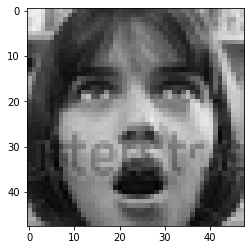

In [151]:
img = test_images[297]
print(predict(img))
show_image(img)

Составляем матрицу ошибок и высчитываем точность

In [0]:
# Возвращаем список эмоций переданных изображений
def make_emotions_list(images):
  emotions = []
  for image in images:
    emotions.append(get_emotion(get_index_of_max(image)))
  return emotions

# Вычисление матрицы ошибок
def confusion_matrix(predicted, test):
  result_matrix = []
  for key, emotion in emotions:
    counts = []

    for k, e in emotions:
      counts.append(0)

    for i in range(0, len(test)):
      if (test[i] == emotion and test[i] == predicted[i]):
        counts[key] += 1
      elif (test[i] == emotion):
        counts[get_index_by_emotion(predicted[i])] += 1

    result_matrix.append(["%.3f" % (count / sum(counts)) for count in counts])
  return result_matrix

# Вывод матрицы ошибок
def show_confusion_matrix(values):
  groups = [v for k, v in emotions]
  fig, ax = plt.subplots(figsize=(13,10))  
  sns.heatmap(values, annot=True, xticklabels=groups, yticklabels=groups, linewidths=2, cmap='Blues')

# Перевод матрицы эмоций в массив
def emotion_matrix_to_array(matrix):
  result = []
  for i in range(0, len(matrix)):
    for j in range(0, len(matrix[i])):
      #print(matrix[i])
      if (matrix[i][j] == 1):
        result.append(j)

  return result

# Возвращает количество верных утверждений модели
def calculate_true_predicts_count(predicted, correct):
  count = 0
  for i in range(0, len(predicted)):
    if (predicted[i] == correct[i]):
      count += 1

  return count

Точность модели: 0.6489272777932572


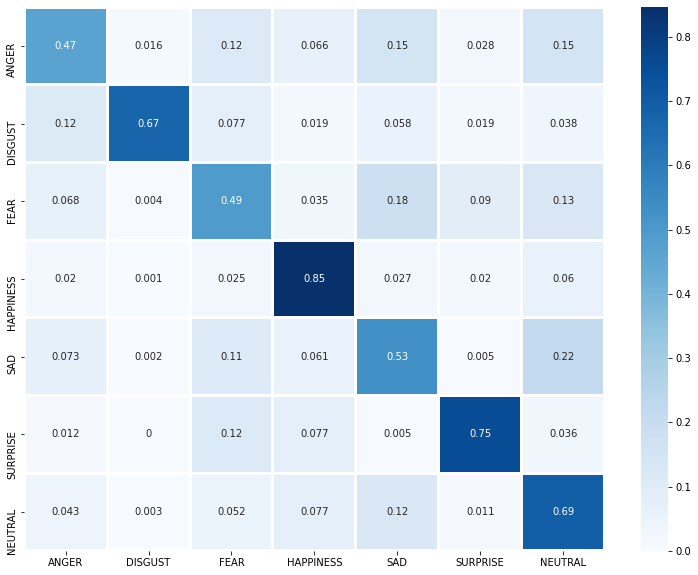

In [159]:
predicted_images = model.predict(test_images)

predicted_emotions = make_emotions_list(predicted_images)
correct_emotions = [get_emotion(emotion) for emotion in emotion_matrix_to_array(test_emotions.values)]

values = np.array(confusion_matrix(predicted_emotions, correct_emotions)).astype(np.float)
print("Точность модели: {0}".format(calculate_true_predicts_count(predicted_emotions, correct_emotions) / len(correct_emotions)))
show_confusion_matrix(values)

## Реальное использование
Для использования модели, следует обучить ее всеми изображениями, не разделяя на тестовые и обучающие данные.

In [168]:
train_images, valid_images, train_emotions, valid_emotions = train_test_split(all_images, all_emotions, test_size=0.1, random_state=41)

print("Размер обучающей подборки: {0}".format(len(train_images)))
print("Размер валидационной подборки: {0}".format(len(valid_images)))

Размер обучающей подборки: 32298
Размер валидационной подборки: 3589


In [171]:
model = create_model()
train_model(model, train_images, train_emotions, valid_images, valid_emotions)

Epoch 1/100
505/505 [==============================] - 14s 28ms/step - loss: 1.9936 - accuracy: 0.2148 - val_loss: 1.8218 - val_accuracy: 0.2402
Epoch 2/100
505/505 [==============================] - 13s 26ms/step - loss: 1.8311 - accuracy: 0.2476 - val_loss: 1.8327 - val_accuracy: 0.2424
Epoch 3/100
505/505 [==============================] - 13s 26ms/step - loss: 1.7597 - accuracy: 0.2856 - val_loss: 1.9836 - val_accuracy: 0.2469
Epoch 4/100
505/505 [==============================] - 13s 26ms/step - loss: 1.6655 - accuracy: 0.3318 - val_loss: 1.9130 - val_accuracy: 0.2494
Epoch 5/100
505/505 [==============================] - 13s 26ms/step - loss: 1.5695 - accuracy: 0.3853 - val_loss: 1.4697 - val_accuracy: 0.4249
Epoch 6/100
505/505 [==============================] - 13s 26ms/step - loss: 1.4779 - accuracy: 0.4201 - val_loss: 1.4227 - val_accuracy: 0.4422
Epoch 7/100
505/505 [==============================] - 13s 26ms/step - loss: 1.4308 - accuracy: 0.4385 - val_loss: 1.3393 - val_ac

In [172]:
model.save("fer_model_final.tf")

INFO:tensorflow:Assets written to: fer_model_final.tf/assets


INFO:tensorflow:Assets written to: fer_model_final.tf/assets


## Конвертация в tflite
Так же можно конвертировать Keras модель в tflite.

In [173]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open("model.tflite", "wb").write(tfmodel)

23617760

Для использования модели tflite следует знать какой формат данных принимает модель.<br/>
**Вход**: массив матриц 48х48 пикселей<br/>
**Выход**: массив значений типа float, где наибольшее обозначает вероятную эмоцию

In [174]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

print("Формат входных данных: {0}".format(interpreter.get_input_details()[0]['shape']))
print("Тип входных данных: {0}".format(interpreter.get_input_details()[0]['dtype']))

print("Формат входных данных: {0}".format(interpreter.get_output_details()[0]['shape']))
print("Тип входных данных: {0}".format(interpreter.get_output_details()[0]['dtype']))

Формат входных данных: [ 1 48 48  1]
Тип входных данных: <class 'numpy.float32'>
Формат входных данных: [1 7]
Тип входных данных: <class 'numpy.float32'>
